# twitter民众聚类分析

In [1]:
import pandas as pd
import numpy as np  

In [2]:
df = pd.read_csv('../data/twitter_capital_data.csv')
df.head()

,datetime,description,title
0,2017-06-27 04:20:31,Vietnam will not consider abolishing capital p...,Vietnam not to drop death penalty for corruption
1,2017-06-27 04:41:27,Convicted cop - killer Ronell Wilson will live...,Prosecutors end death penalty bid for cop-kill...
2,2017-06-27 05:00:51,"A city council member in Ohio, the state with ...",Ohio city rep proposes new system to combat ex...
3,2017-06-27 05:05:11,Questions From Readers Is there any hope of a ...,Questions From Readers — Watchtower ONLINE LIB...
4,2017-06-27 05:06:06,A Lebanon home where a man was found dead and ...,Prosecutors will weigh whether to seek death p...


In [3]:
# 结合标题和描述，作为特征提取
df['character'] = df['title'] + '[SEP]' + df['description']

In [4]:
import h5py
import numpy as np

with h5py.File('../data/capital.h5', 'r') as h5_file:
    # 读取数据集
    data = h5_file['data'][:]
    datetimes = h5_file['datetime'][:]
    descriptions = h5_file['description'][:]
    targets = h5_file['target'][:]
    target_months = h5_file['target-month'][:]
    test_idxs = h5_file['test_idxs'][:]
    texts = h5_file['text'][:]
    tittles = h5_file['title'][:]
    train_idxs = h5_file['train_idxs'][:]
    valid_idxs = h5_file['val_idxs'][:]

In [5]:
df['character_vector'] = data.tolist()

# K-Means聚类

In [50]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 将character_vector转换为numpy数组
vectors = np.array(df['character_vector'].tolist())

# K-Means聚类
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(vectors)

# 添加聚类标签到数据框
df['K-Means Cluster'] = clusters

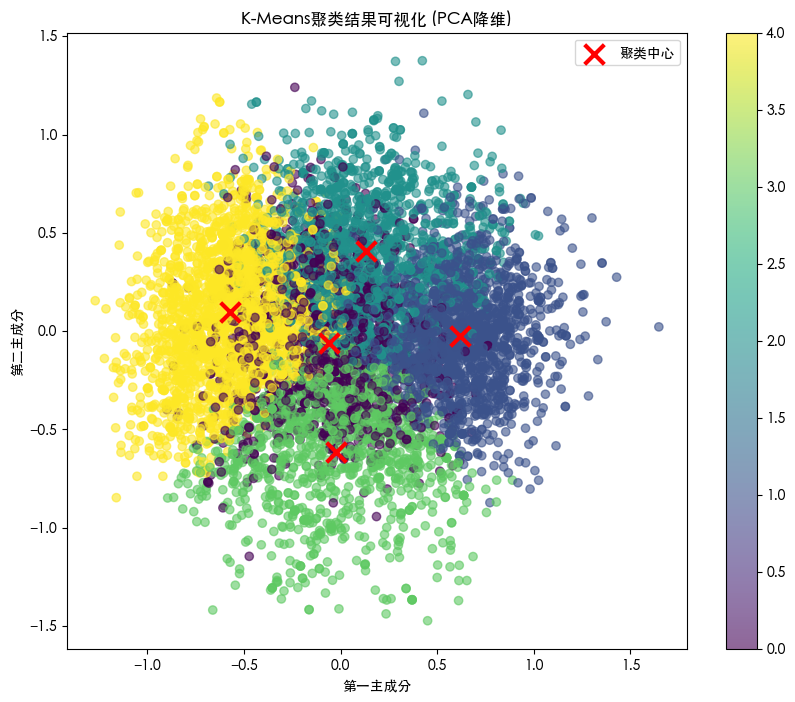

各聚类的样本数量:
0    1276
1    1810
2    1541
3    1149
4    2129
Name: count, dtype: int64


In [8]:
from sklearn.decomposition import PCA

# 使用PCA降维进行可视化
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体
# 使用PCA将高维向量降到2维
pca = PCA(n_components=2, random_state=42)
vectors_2d = pca.fit_transform(vectors)

# 创建散点图
plt.figure(figsize=(10, 8))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('K-Means聚类结果可视化 (PCA降维)')
plt.xlabel('第一主成分')
plt.ylabel('第二主成分')

# 添加聚类中心
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', marker='x', s=200, linewidths=3, label='聚类中心')
plt.legend()
plt.show()

# 显示各聚类的数量分布
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("各聚类的样本数量:")
print(cluster_counts)

# faiss聚类

In [51]:
import faiss

# 使用已有的vectors数据，它已经是float32类型
d = vectors.shape[1]  # 获取向量维度
k = 4  # 聚类中心数量
niter = 200  # 迭代次数

# 创建faiss kmeans对象
faiss_kmeans = faiss.Kmeans(d=d, k=k, niter=niter, verbose=True)
faiss_kmeans.train(vectors)

# 得到聚类中心
centroids = faiss_kmeans.centroids

# 给样本分配聚类标签
D, I = faiss_kmeans.index.search(vectors, 1)
faiss_labels = I.reshape(-1)  # 每个数据点的聚类标签

# 添加faiss聚类标签到数据框
df['faiss_cluster'] = faiss_labels

Sampling a subset of 1024 / 7905 for training
Clustering 1024 points in 300D to 4 clusters, redo 1 times, 200 iterations
  Preprocessing in 0.00 s
  Iteration 199 (0.10 s, search 0.09 s): objective=1603.86 imbalance=1.052 nsplit=0       


In [61]:
for i in range(4):
    print(f"faiss聚类{i}的样本数量: {np.sum(faiss_labels == i)}")
    print('示例文本:')
    for t in df[df['faiss_cluster'] == i][:5]['character'].tolist():
        print(t)

faiss聚类0的样本数量: 2055
示例文本:
Questions From Readers — Watchtower ONLINE LIBRARY[SEP]Questions From Readers Is there any hope of a resurrection for a baby that dies in its mother's womb?. For those who have never suffered the loss of an unborn baby in this way, it may be difficult to imagine the feelings of those who have.. One mother lost five children before they were born.. In time, she felt blessed to raise two healthy sons.. To the end of her days, she knew just how old her stillborn and miscarried babies would have been had they survived.. Do such Christians have a basis for hoping in a resurrection to restore what they have lost?. The simple answer to the question is that we do not know.. The Bible never directly addresses the matter of a resurrection for babies who were stillborn or lost through a miscarriage.. Nonetheless, God's Word does contain principles that bear on the question and that may offer a measure of comfort.. First, from Jehovah's viewpoint, when does the life of a 

# 快速聚类

In [13]:
import csv
import os
import time

from sentence_transformers import SentenceTransformer, util

# Model for computing sentence embeddings. We use one trained for similar questions detection
model = SentenceTransformer("all-MiniLM-L6-v2")

In [14]:
corpus_sentences = df['character'].tolist()
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(corpus_sentences, batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Encode the corpus. This might take a while


Batches:   0%|          | 0/124 [00:00<?, ?it/s]

In [15]:
corpus_embeddings.shape

torch.Size([7905, 384])

In [16]:
print("Start clustering")
start_time = time.time()

# Two parameters to tune:
# min_cluster_size: Only consider cluster that have at least 25 elements
# threshold: Consider sentence pairs with a cosine-similarity larger than threshold as similar
clusters = util.community_detection(corpus_embeddings, min_community_size=100, threshold=0.75)

print(f"Clustering done after {time.time() - start_time:.2f} sec")

Start clustering
Clustering done after 1.77 sec


In [17]:
len(clusters)

4

In [18]:
# Print for all clusters the top 3 and bottom 3 elements
for i, cluster in enumerate(clusters):
    print(f"\nCluster {i + 1}, #{len(cluster)} Elements ")
    for sentence_id in cluster[0:3]:
        print("\t", corpus_sentences[sentence_id])
    print("\t", "...")
    for sentence_id in cluster[-3:]:
        print("\t", corpus_sentences[sentence_id])


Cluster 1, #210 Elements 
	 Death penalty dispute goes to Florida Supreme Court[SEP]State Attorney Aramis Ayala and Florida Governor Rick Scott (Photo: WKMG/Getty Images) TALLAHASSEE, Fla.. Rick Scott's power to strip a prosecutor of murder cases because she won't seek the death penalty will be tested before the state Supreme Court.. State Attorney Aramis Ayala is asking the court to block Scott from assigning her Orlando - area murder cases to a neighboring prosecutor.. Justices will hear arguments Wednesday in the dispute that began in March when Ayala said she wouldn't seek the death penalty against Markeith Loyd, who is charged with the fatal shooting of an Orlando police officer, or any other death case.. Scott said he reassigned the cases because Ayala isn't following Florida law.. Ayala argues that Scott doesn't have the right to take the cases from her because she's independently elected.
	 Death penalty dispute goes to Florida Supreme Court[SEP]Rick Scott's power to strip a p

# LDA

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pandas as pd

class SklearnLDA:
    def __init__(self, n_topics=10, random_state=42):
        self.n_topics = n_topics
        self.random_state = random_state
        self.vectorizer = None
        self.lda_model = None
        self.feature_names = None
    
    def fit(self, documents, max_features=1000, ngram_range=(1, 2)):
        """训练LDA模型"""
        # 文本向量化
        self.vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words=stop_words,
            lowercase=True
        )
        
        # 转换文档为词频矩阵
        doc_term_matrix = self.vectorizer.fit_transform(documents)
        self.feature_names = self.vectorizer.get_feature_names_out()
        
        # 训练LDA模型
        self.lda_model = LatentDirichletAllocation(
            n_components=self.n_topics,
            random_state=self.random_state,
            max_iter=200,
            learning_method='online',
            learning_offset=50.0,
            doc_topic_prior=None,  # 使用默认alpha
            topic_word_prior=None   # 使用默认beta
        )
        
        self.lda_model.fit(doc_term_matrix)
        return self
    
    def get_topics(self, n_words=10):
        """获取主题词汇"""
        topics = []
        for topic_idx, topic in enumerate(self.lda_model.components_):
            top_words_idx = topic.argsort()[-n_words:][::-1]
            top_words = [self.feature_names[i] for i in top_words_idx]
            top_weights = [topic[i] for i in top_words_idx]
            topics.append(list(zip(top_words, top_weights)))
        return topics
    
    def transform(self, documents):
        """预测文档主题分布"""
        doc_term_matrix = self.vectorizer.transform(documents)
        return self.lda_model.transform(doc_term_matrix)
    
    def print_topics(self, n_words=10):
        """打印主题"""
        topics = self.get_topics(n_words)
        for i, topic in enumerate(topics):
            print(f"Topic {i}:")
            words = [f"{word}({weight:.3f})" for word, weight in topic]
            print("  " + ", ".join(words))
            print()

# 使用示例
documents = df['character'].tolist()

sklearn_lda = SklearnLDA(n_topics=4)
sklearn_lda.fit(documents)
sklearn_lda.print_topics()

/opt/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'll', 'mon', 'sep', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


Topic 0:
  police(7042.984), murder(3976.162), told(3501.306), sep(2978.957), court(2909.340), family(2482.783), child(2304.686), people(2267.116), accused(2103.661), killed(2046.920)

Topic 1:
  court(8317.719), execution(5606.110), punishment(3836.423), supreme(3378.709), supreme court(3264.082), justice(3176.665), row(3055.128), life(2861.813), executions(2766.137), people(2441.267)

Topic 2:
  rights(4114.157), people(3762.739), human(3484.065), punishment(3015.383), government(2804.338), human rights(2684.379), sep(2599.302), international(2365.178), drug(2327.975), law(2246.096)

Topic 3:
  attorney(3249.005), court(3188.919), florida(3127.733), county(2330.619), ayala(2074.830), scott(1722.240), office(1615.108), judge(1577.775), prosecutors(1566.336), murder(1487.966)



ModuleNotFoundError: No module named 'pyLDAvis.sklearn'

In [7]:
f = open('../data/stop_words.txt', 'r', encoding='utf-8')
stop_words = f.readlines()
f.close()
stop_words = [word.strip() for word in stop_words if word.strip()]
stop_words.extend(['capital', '[SEP]', 'death', 'penalty', 'crime'])

In [42]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
class LSATopicModel:
    def __init__(self, n_topics=10, random_state=42):
        self.n_topics = n_topics
        self.random_state = random_state
        self.vectorizer = None
        self.lsa_model = None
        self.feature_names = None
    
    def fit(self, documents, max_features=1000):
        """训练LSA模型"""
        # 使用TF-IDF向量化
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words=stop_words,
            lowercase=True,
            ngram_range=(1, 2)
        )
        
        doc_term_matrix = self.vectorizer.fit_transform(documents)
        self.feature_names = self.vectorizer.get_feature_names_out()
        
        # SVD分解
        self.lsa_model = TruncatedSVD(
            n_components=self.n_topics,
            random_state=self.random_state
        )
        
        self.lsa_model.fit(doc_term_matrix)
        return self
    
    def get_topics(self, n_words=10):
        """获取主题词汇"""
        topics = []
        for topic_idx, topic in enumerate(self.lsa_model.components_):
            top_words_idx = topic.argsort()[-n_words:][::-1]
            top_words = [self.feature_names[i] for i in top_words_idx]
            top_weights = [topic[i] for i in top_words_idx]
            topics.append(list(zip(top_words, top_weights)))
        return topics
    
    def transform(self, documents):
        """预测文档主题分布"""
        doc_term_matrix = self.vectorizer.transform(documents)
        return self.lsa_model.transform(doc_term_matrix)

# 使用示例
lsa_model = LSATopicModel(n_topics=5)
lsa_model.fit(documents)
topics = lsa_model.get_topics()

In [43]:
topics

[[('court', 0.2440454714008852),
  ('police', 0.1510821687158455),
  ('murder', 0.14283676276523022),
  ('execution', 0.13071253744829817),
  ('people', 0.12745399679503586),
  ('punishment', 0.12353439054103378),
  ('life', 0.1133742534933501),
  ('executions', 0.10558775019485747),
  ('county', 0.10213445563803367),
  ('law', 0.10155923595225792)],
 [('ayala', 0.26048080910299937),
  ('florida', 0.17994805456384202),
  ('police', 0.15084749724268454),
  ('scott', 0.14825175408610294),
  ('attorney', 0.14392958647755577),
  ('county', 0.13509837893990082),
  ('court', 0.12971598737075787),
  ('murder', 0.1165724433155322),
  ('seek', 0.09857072124758298),
  ('prosecutor', 0.08693969487674055)],
 [('ayala', 0.3730080313665554),
  ('florida', 0.2792119507471063),
  ('scott', 0.19027432822093043),
  ('supreme court', 0.18470053306583484),
  ('supreme', 0.18344266237964818),
  ('court', 0.17530714154724605),
  ('execution', 0.14819247707639224),
  ('executions', 0.12948248866471046),
  ('

In [1]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置图片清晰度
plt.rcParams['figure.dpi'] = 600

# 正常显示中文，设置字体为宋体
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体# 正常显示中文，设置字体为 WenQuanYi Zen Hei
#plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']

# 明确负号显示
mpl.rcParams['axes.unicode_minus'] = False

# 加载数据
df = pd.read_csv("/Users/luoyiti/CodeProject/Capital-Punishment-Research/data/twitter_capital_data.csv")

# 使用 TextBlob 进行情感分析
def get_sentiment_score(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity


In [18]:
# 应用函数到 description 列，获取情感得分
df['sentiment_score'] = df['description'].apply(get_sentiment_score)

# 定义一个函数来对情感得分进行分类
def get_sentiment_label(score):
    if score > 0:
        return 'Positive'
    else:
        return 'Negative'

# 应用函数到 sentiment_score 列，获取情感标签
df['sentiment_label'] = df['sentiment_score'].apply(get_sentiment_label)

# 查看总体情感趋向分布情况
sentiment_distribution = df['sentiment_label'].value_counts(normalize=True) * 100

# 输出结果（保留两位小数）
print(sentiment_distribution.round(2))


sentiment_label
Positive    64.53
Negative    35.47
Name: proportion, dtype: float64


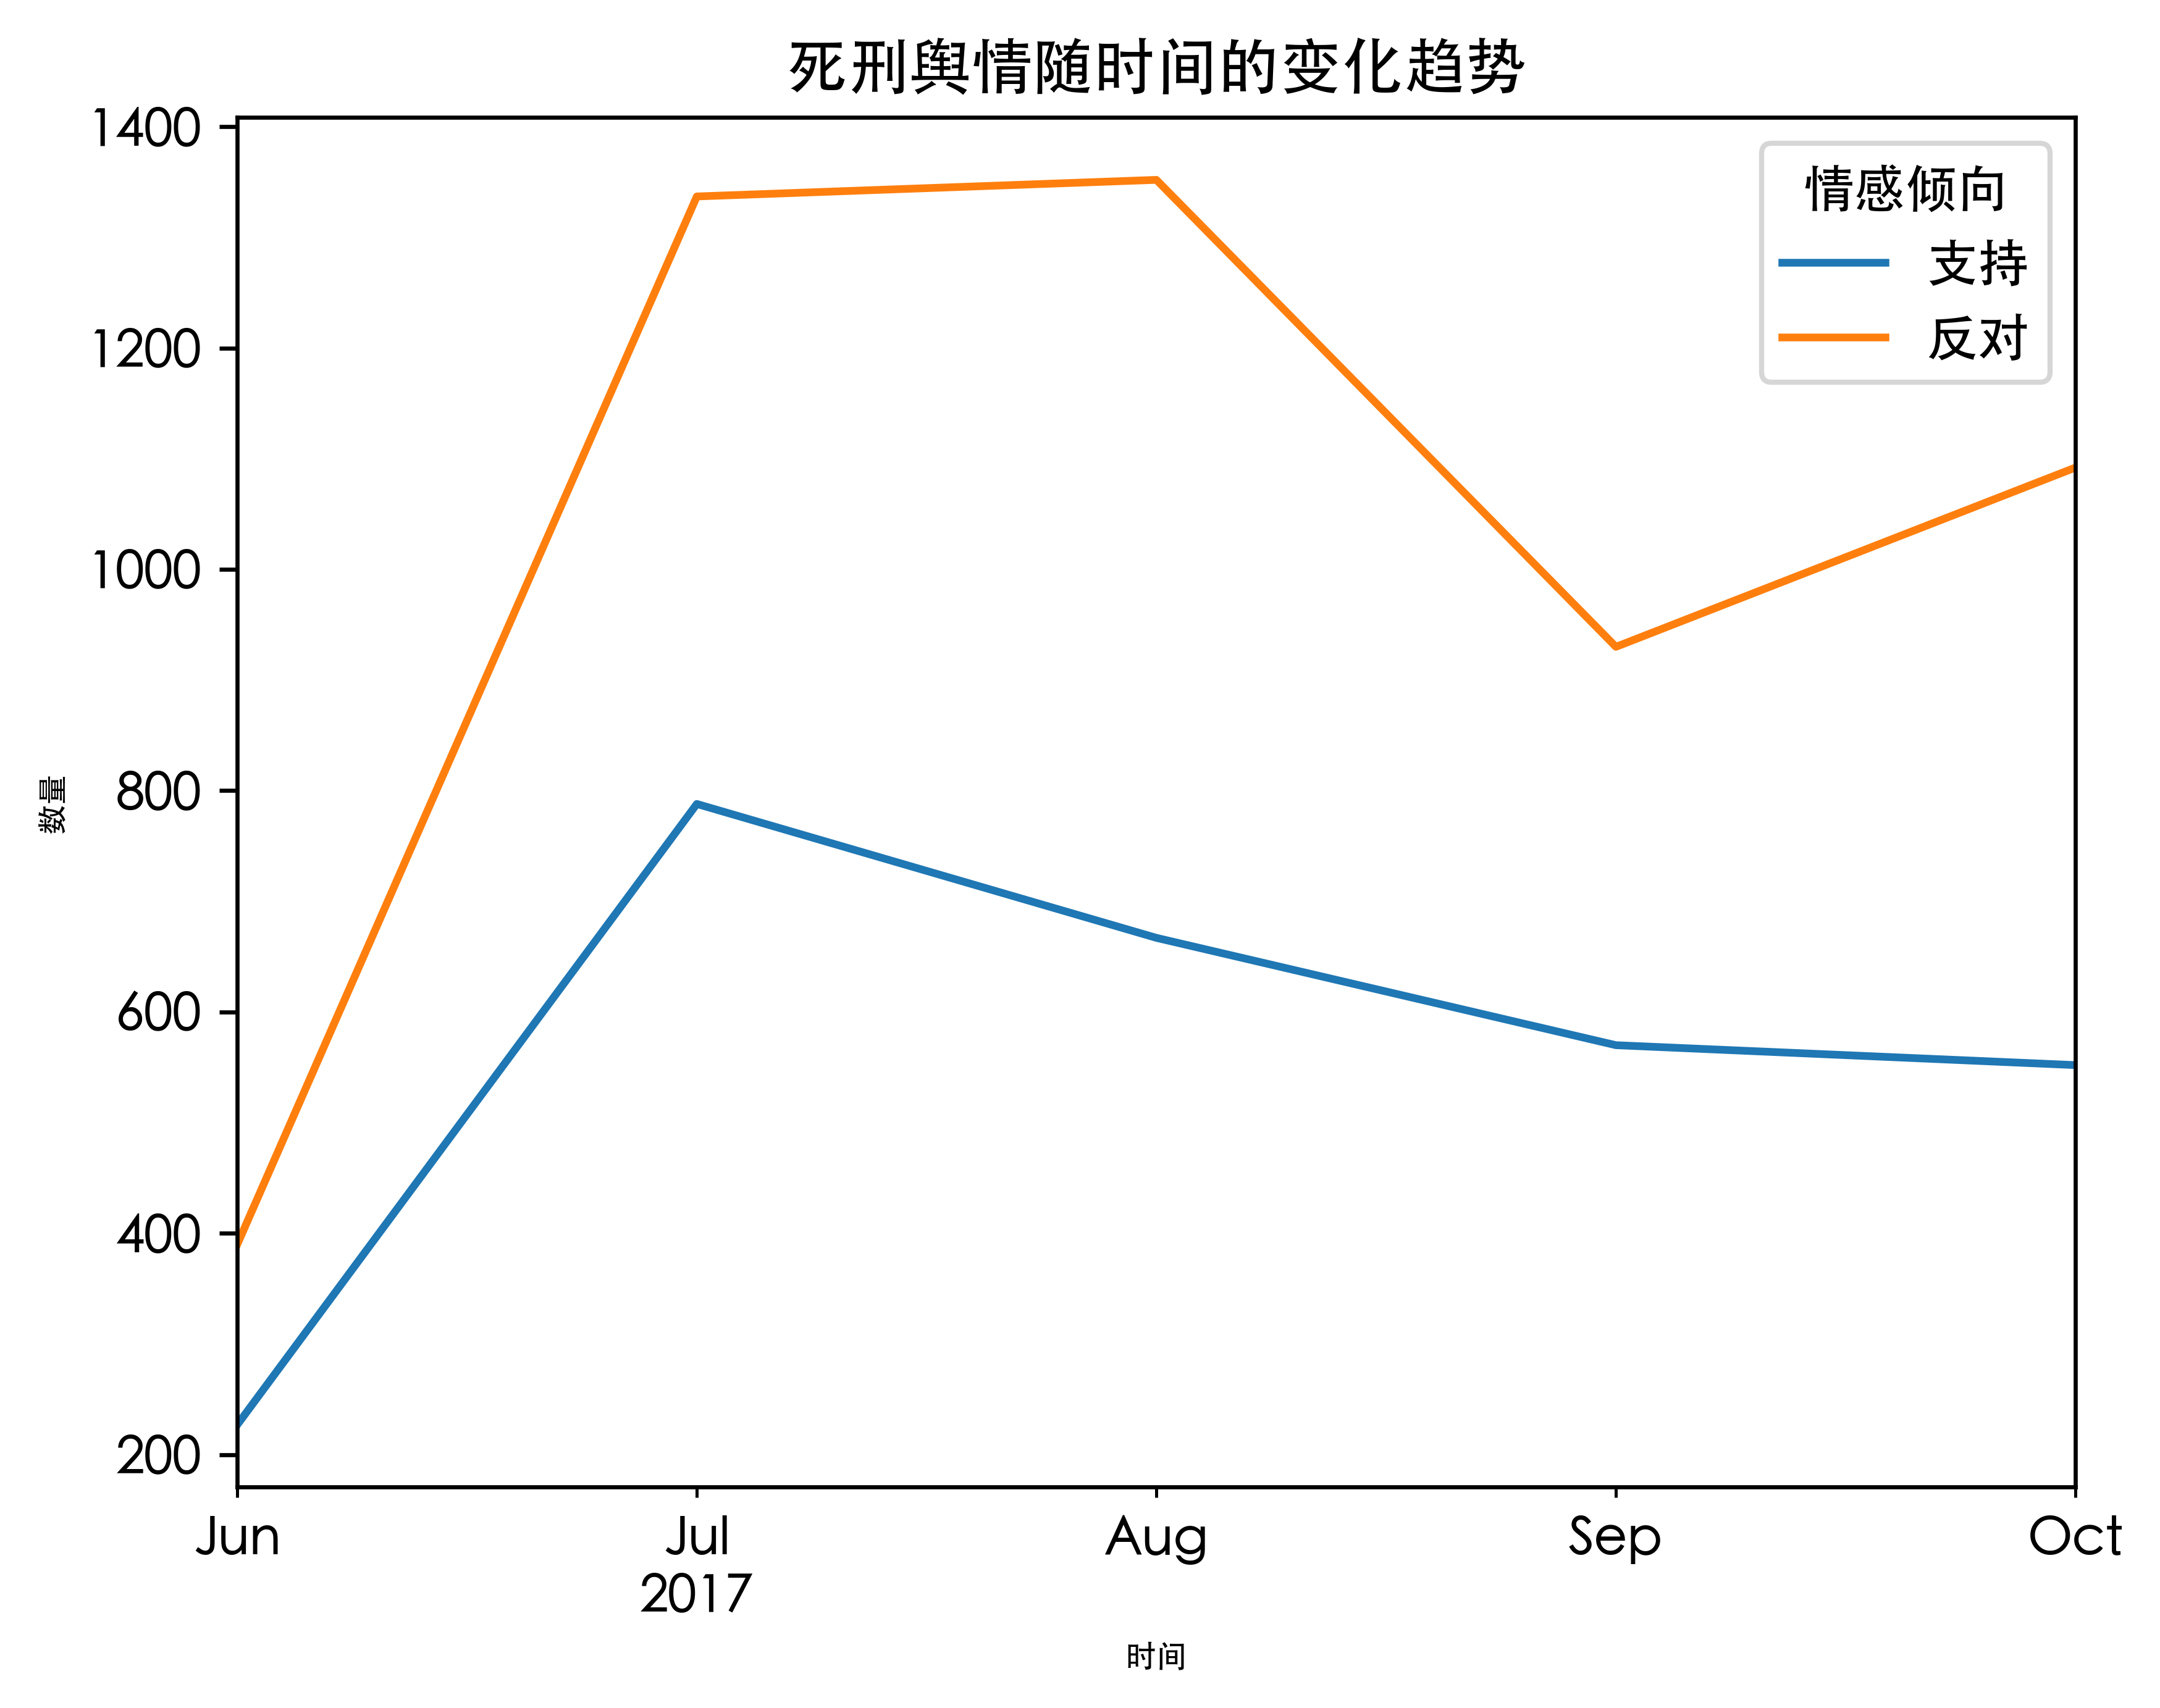

In [22]:
# 将 datetime 列转换为日期时间类型
df['datetime'] = pd.to_datetime(df['datetime'])

# 按年月统计不同情感的数量
time_series_data = df.groupby([df['datetime'].dt.to_period('M'), 'sentiment_label']).size().unstack(fill_value=0)

time_series_data.rename(columns={'Positive': '反对', 'Negative': '支持'}, inplace=True) 
# 绘制时间序列图


ax = time_series_data.plot(title='死刑舆情随时间的变化趋势')
# 设置时间序列图横纵坐标名称字号为 6
ax.set_xlabel('时间', fontsize=6)
ax.set_ylabel('数量', fontsize=6)
ax.legend(title='情感倾向')


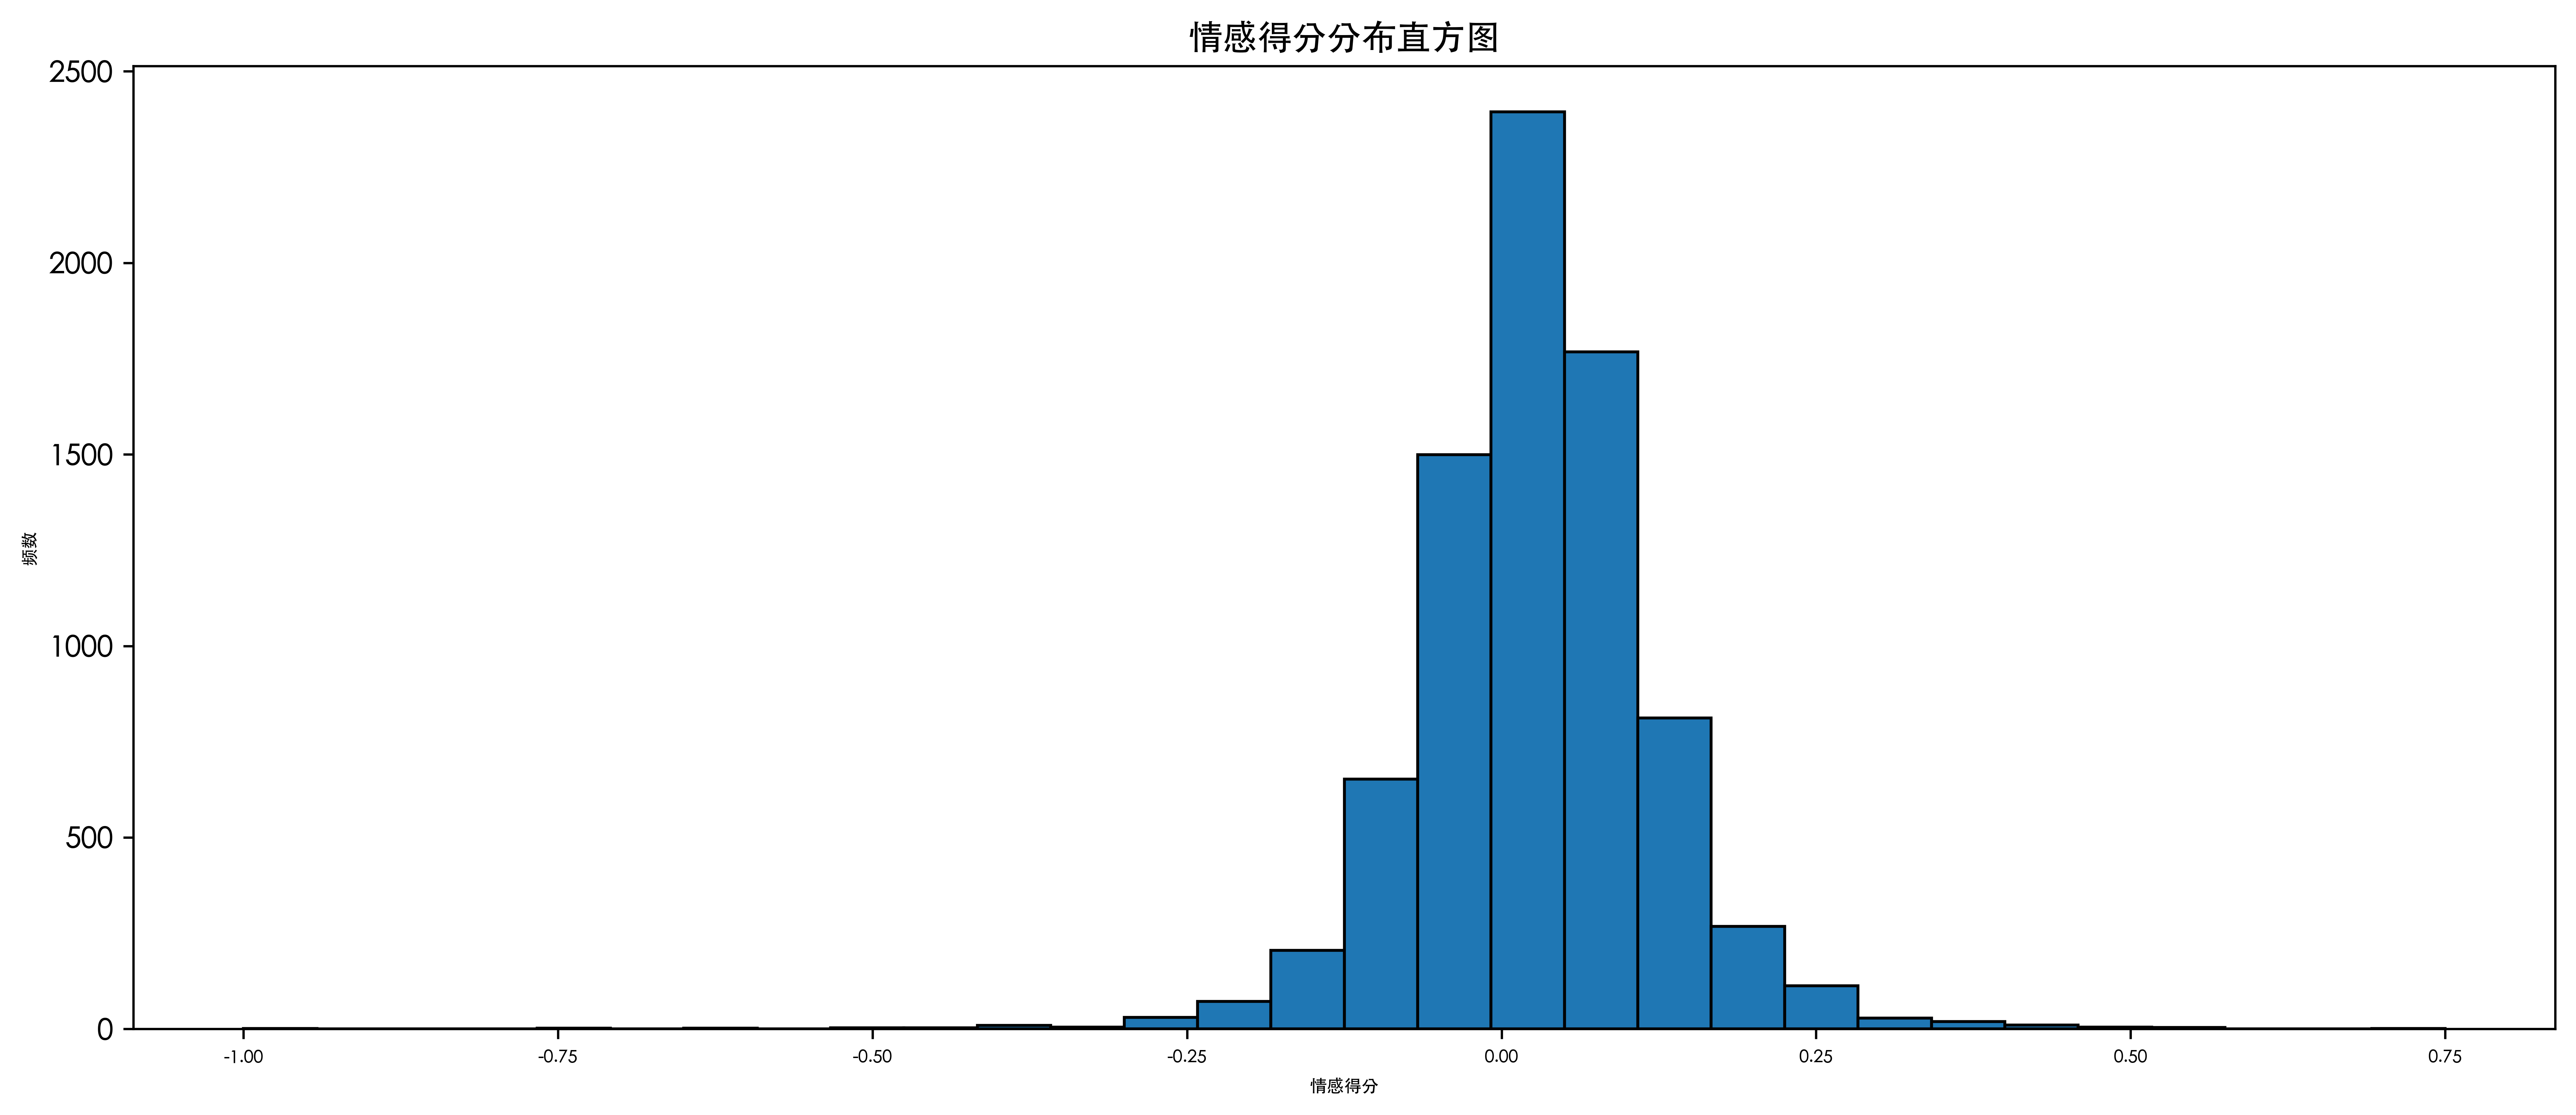

In [20]:
# 绘制情感得分直方图
plt.figure(figsize=(15, 6))
plt.hist(df['sentiment_score'], bins=30, edgecolor='black')
plt.title('情感得分分布直方图')
plt.xlabel('情感得分', fontsize=6)
plt.xticks(fontsize=6)
plt.ylabel('频数', fontsize=6)

plt.show()